In [1]:
!pip install lightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.2/613.2 kB 11.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=c49c33e891471c1f10a6fabd420dbe4d60d63b589b7e13d12fad575ff8f72413
  Stored in directory: /root/.cache/pip/wheels/a9/8b/1f/b8233836d5798e3224c2442947e9639f220095de8bf46e800c
Successfully built antlr4-python3-runtime


In [2]:
import torch
from torch import nn
import torchvision
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from datetime import datetime, date

from lightly.data import LightlyDataset
from lightly.data.collate import VICRegCollateFunction
from lightly.models.modules import BarlowTwinsProjectionHead
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from lightly.loss import VICRegLoss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


Загрузим и обучим модель 

In [ ]:

class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        # не использовать при обучении
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

print("Starting Training")
model.train()
for epoch in range(10):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Проверим на линейной регрессии

In [ ]:
model.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


Посчитаем f1_score и Accuracy на тесте

In [ ]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

for (x0, x1), _1, _2 in test:
  print(model(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 512])

f1_score:  0.22109129271764755

Accuracy:  0.2265625


Возьмем более мощную 

In [3]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
backbone = nn.Sequential(*list(resnet.children())[:-1])
model_pre = VICReg(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_pre.to(device)

cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
dataset = LightlyDataset.from_torch_dataset(cifar10)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

criterion = VICRegLoss()
optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

print("Starting Training")
model_pre.train()
for epoch in range(10):
    total_loss = 0
    for (x0, x1), _, _ in dataloader:
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model_pre(x0)
        z1 = model_pre(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip

Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10

Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.64019

epoch: 01, loss: 21.33384

epoch: 02, loss: 21.14777

epoch: 03, loss: 20.99643

epoch: 04, loss: 20.87483

epoch: 05, loss: 20.76828

epoch: 06, loss: 20.69215

epoch: 07, loss: 20.61201

epoch: 08, loss: 20.54822

epoch: 09, loss: 20.47334


In [4]:
model_pre.eval()
clf = LogisticRegression(random_state=0)
for (x0, x1), _1, _2 in dataloader:
  clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
  break

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


In [5]:
cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
testset = LightlyDataset.from_torch_dataset(cifar10_test)
# or create a dataset from a folder containing images or videos:
# dataset = LightlyDataset("path/to/folder")

collate_fn = VICRegCollateFunction(input_size=32)

test = torch.utils.data.DataLoader(
    testset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

for (x0, x1), _1, _2 in test:
  print(model_pre(x0.to(device)).shape)
  print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
  print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
  break

Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])

f1_score:  0.3031101612031156

Accuracy:  0.32421875


Протестируем поведение модели при изменении некоторых параметров

In [4]:
class VICReg(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(2048, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        if self.training:
          out = self.projection_head(x)
        else:
          out = x
        return out


def modeler(a={'lambda':[20,25,30], 'mu': [20,25,30], 'nu': [0.9, 1, 1.1]}):
    res = []
    losses_plots = []
    for lamb in a['lambda']:
        for mu in a['mu']:
            for nu in a['nu']:
                loes = []
                print("Experiment with \n lambda: ", lamb, '\n', 'mu_param: ', mu,  '\n', 'nu_param: ', nu, '\n')
                resnet = torch.hub.load('facebookresearch/vicreg:main', 'resnet50')
                backbone = nn.Sequential(*list(resnet.children())[:-1])
                model_pre = VICReg(backbone)

                device = "cuda" if torch.cuda.is_available() else "cpu"
                model_pre.to(device)

                cifar10 = torchvision.datasets.CIFAR10("datasets/cifar10", train=True, download=True)
                dataset = LightlyDataset.from_torch_dataset(cifar10)
                # or create a dataset from a folder containing images or videos:
                # dataset = LightlyDataset("path/to/folder")

                collate_fn = VICRegCollateFunction(input_size=32)


                dataloader = torch.utils.data.DataLoader(
                    dataset,
                    batch_size=256,
                    collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True,
                    num_workers=4,
                )

                criterion = VICRegLoss(lambda_param=lamb, mu_param=mu, nu_param=nu)
                optimizer = torch.optim.SGD(model_pre.parameters(), lr=0.06)

                print("Starting Training")
                model_pre.train()
                for epoch in range(10):
                    total_loss = 0
                    for (x0, x1), _, _ in dataloader:
                        x0 = x0.to(device)
                        x1 = x1.to(device)
                        z0 = model_pre(x0)
                        z1 = model_pre(x1)
                        loss = criterion(z0, z1)
                        total_loss += loss.detach()
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    avg_loss = total_loss / len(dataloader)
                    loes.append(avg_loss)
                    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
                
                losses_plots.append(loes)

                model_pre.eval()
                clf = LogisticRegression(random_state=0)
                for (x0, x1), _1, _2 in dataloader:
                    clf.fit(model_pre(x0.to(device)).cpu().detach().numpy(), _1)
                    break

        
                cifar10_test = torchvision.datasets.CIFAR10("datasets/cifar10", train=False, download=True)
                testset = LightlyDataset.from_torch_dataset(cifar10_test)
                # or create a dataset from a folder containing images or videos:
                # dataset = LightlyDataset("path/to/folder")

                collate_fn = VICRegCollateFunction(input_size=32)

                test = torch.utils.data.DataLoader(
                    testset,
                    batch_size=256,
                        collate_fn=collate_fn,
                    shuffle=True,
                    drop_last=True,
                    num_workers=4,
                )
                for (x0, x1), _1, _2 in test:
                    print(model_pre(x0.to(device)).shape)
                    print("f1_score: ", f1_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()), average='macro'))
                    print("Accuracy: ", accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy())))
                    break
                res.append((lamb, mu, nu, accuracy_score(_1, clf.predict(model_pre(x0.to(device)).cpu().detach().numpy()))))
    return res, losses_plots

In [5]:
result, plo = modeler({'lambda':[20,25,30], 'mu': [25], 'nu': [1]})

Experiment with 

 lambda:  20 

 mu_param:  25 

 nu_param:  1 




Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip

Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10

Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


epoch: 00, loss: 20.90761

epoch: 01, loss: 20.67711

epoch: 02, loss: 20.52335

epoch: 03, loss: 20.39984

epoch: 04, loss: 20.28861

epoch: 05, loss: 20.18022

epoch: 06, loss: 20.09430

epoch: 07, loss: 20.02786

epoch: 08, loss: 19.97095

epoch: 09, loss: 19.89023


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])

f1_score:  0.26660101044547346

Accuracy:  0.26953125

Experiment with 

 lambda:  25 

 mu_param:  25 

 nu_param:  1 




Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified

Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


epoch: 00, loss: 21.64521

epoch: 01, loss: 21.33784

epoch: 02, loss: 21.15344

epoch: 03, loss: 21.00083

epoch: 04, loss: 20.88346

epoch: 05, loss: 20.77632

epoch: 06, loss: 20.70036

epoch: 07, loss: 20.61836

epoch: 08, loss: 20.54167

epoch: 09, loss: 20.48841


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])

f1_score:  0.3594784811839936

Accuracy:  0.359375

Experiment with 

 lambda:  30 

 mu_param:  25 

 nu_param:  1 




Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified

Starting Training


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


epoch: 00, loss: 22.17760

epoch: 01, loss: 21.77326

epoch: 02, loss: 21.57330

epoch: 03, loss: 21.41125

epoch: 04, loss: 21.29565

epoch: 05, loss: 21.19641

epoch: 06, loss: 21.10430

epoch: 07, loss: 21.02945

epoch: 08, loss: 20.97736

epoch: 09, loss: 20.91443


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.



Increase the number of iterations (max_iter) or scale the data as shown in:

    https://scikit-learn.org/stable/modules/preprocessing.html

Please also refer to the documentation for alternative solver options:

    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

  n_iter_i = _check_optimize_result(


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(


torch.Size([256, 2048])

f1_score:  0.30764106136999575

Accuracy:  0.31640625


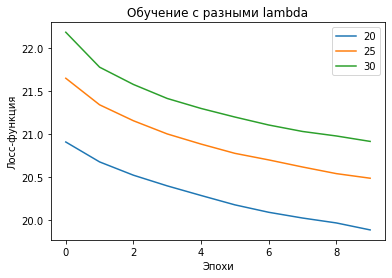

In [8]:
nubers = []
for t in range(len(plo)):
    r = []
    for i in range(len(plo[t])):
        r.append(plo[t][i].cpu().detach().numpy())
    nubers.append(r)
data = np.array(nubers)


plt.plot(data[0], label="20")
plt.plot(data[1], label="25")
plt.plot(data[2], label="30")
plt.title("Обучение с разными lambda")
plt.ylabel("Лосс-функция")
plt.xlabel("Эпохи")
plt.legend()

In [7]:
acuur = []
for ac in result:
    acuur.append(ac[3])
print('Lambda: ', result[np.argmax(acuur)][0], '; mu param: ', result[np.argmax(acuur)][1],
      '; nu param: ', result[np.argmax(acuur)][2], '\nBest Accuracy: ', result[np.argmax(acuur)][3])

Lambda:  25 ; mu param:  25 ; nu param:  1 

Best Accuracy:  0.359375


In [5]:
result, plo = modeler({'lambda':[25], 'mu': [20,25,30], 'nu': [1]})

Experiment with 
 lambda:  25 
 mu_param:  20 
 nu_param:  1 



Downloading: "https://github.com/facebookresearch/vicreg/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/vicreg/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Starting Training


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 17.91377
epoch: 01, loss: 17.61833
epoch: 02, loss: 17.48278
epoch: 03, loss: 17.38625
epoch: 04, loss: 17.29854
epoch: 05, loss: 17.22791
epoch: 06, loss: 17.16862
epoch: 07, loss: 17.10788
epoch: 08, loss: 17.06091
epoch: 09, loss: 17.02458


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 2048])
f1_score:  0.30219270500278617
Accuracy:  0.3046875
Experiment with 
 lambda:  25 
 mu_param:  25 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 21.63917
epoch: 01, loss: 21.32269
epoch: 02, loss: 21.14813
epoch: 03, loss: 20.99205
epoch: 04, loss: 20.87249
epoch: 05, loss: 20.76821
epoch: 06, loss: 20.68290
epoch: 07, loss: 20.61088
epoch: 08, loss: 20.54846
epoch: 09, loss: 20.48548


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 2048])
f1_score:  0.3341209904213659
Accuracy:  0.34375
Experiment with 
 lambda:  25 
 mu_param:  30 
 nu_param:  1 



Using cache found in /root/.cache/torch/hub/facebookresearch_vicreg_main


Files already downloaded and verified
Starting Training


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 00, loss: 25.15341
epoch: 01, loss: 24.77651
epoch: 02, loss: 24.54486
epoch: 03, loss: 24.34256
epoch: 04, loss: 24.17852
epoch: 05, loss: 24.06552
epoch: 06, loss: 23.94583
epoch: 07, loss: 23.83373
epoch: 08, loss: 23.75220
epoch: 09, loss: 23.65997
Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 2048])
f1_score:  0.312773535517121
Accuracy:  0.3203125


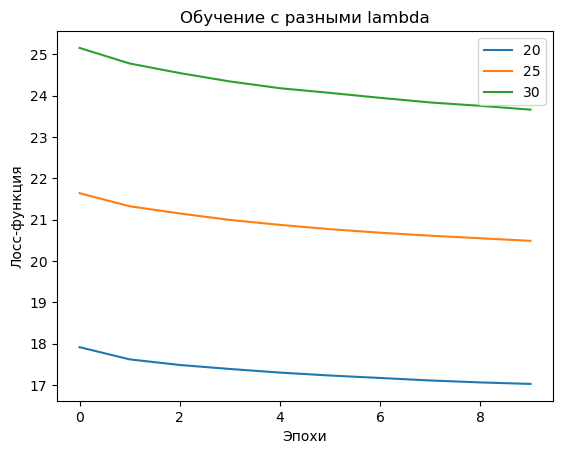

In [6]:
nubers = []
for t in range(len(plo)):
    r = []
    for i in range(len(plo[t])):
        r.append(plo[t][i].cpu().detach().numpy())
    nubers.append(r)
data = np.array(nubers)


plt.plot(data[0], label="20")
plt.plot(data[1], label="25")
plt.plot(data[2], label="30")
plt.title("Обучение с разными lambda")
plt.ylabel("Лосс-функция")
plt.xlabel("Эпохи")
plt.legend()

In [7]:
acuur = []
for ac in result:
    acuur.append(ac[3])
print('Lambda: ', result[np.argmax(acuur)][0], '; mu param: ', result[np.argmax(acuur)][1],
      '; nu param: ', result[np.argmax(acuur)][2], '\nBest Accuracy: ', result[np.argmax(acuur)][3])

Lambda:  25 ; mu param:  25 ; nu param:  1 
Best Accuracy:  0.34375
